# Power sensor applications and analysis

## Setup

I have some Innr SP 120 Plugs (https://shop.innrlighting.com/en/shop/113/smart-plug) that
are connected with zigbee2mqtt (https://github.com/Koenkk/zigbee2mqtt) to HomeAssistant (https://www.home-assistant.io/). For now I'm just looking at my dryer, but I will be generalizing to some other devices at a later stage.

 I would like to use the data from their power sensor to do:
 * Automatic detection of dryer status: off, on (+ mode: running, knitterschutz, ?)
 * Notification when the dryer is done
 * Power consumption (in kWh) of the dryer
 * Estimation of how long the dryer will still be running

# Reading the data and cleaning it up

Data is provided in HomeAssistants database. For this analysis, I've exported the states table to CSV.

In [4]:
%matplotlib inline  
import pandas as pd
df = pd.read_csv('states.csv')

C:\Users\herwinvw\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df

,state_id,domain,entity_id,state,attributes,event_id,last_changed,last_updated,created,context_id,context_user_id
0,1931962,sensor,sensor.dryer_socket_power,0,"{""state"": ""ON"", ""linkquality"": 57, ""power"": 0,...",1942768,2019-07-21 04:38:47.303736,2019-07-24 19:33:37.798263,2019-07-24 19:33:37.821549,cf7353960a7c49e7ac1699e6b64656a2,NaN
1,1931963,sensor,sensor.dryer_socket_linkquality,57,"{""state"": ""ON"", ""linkquality"": 57, ""power"": 0,...",1942769,2019-07-24 19:32:55.819964,2019-07-24 19:33:37.799644,2019-07-24 19:33:37.908586,32c911f3a9154eea8d4f174d5f8f828a,NaN
2,1931964,sensor,sensor.washingmachine_socket_power,0,"{""state"": ""ON"", ""linkquality"": 57, ""voltage"": ...",1942770,2019-07-24 18:02:24.087474,2019-07-24 19:33:47.121706,2019-07-24 19:33:47.143400,9b8d33371d3f45e9af48c060a810673f,NaN
3,1931965,sensor,sensor.washingmachine_socket_linkquality,57,"{""state"": ""ON"", ""linkquality"": 57, ""voltage"": ...",1942771,2019-07-24 19:32:23.148088,2019-07-24 19:33:47.123111,2019-07-24 19:33:47.265248,eb14a5614eaa44008b4a08ea5f1f13fa,NaN
4,1931966,sensor,sensor.processor_use,3,"{""unit_of_measurement"": ""%"", ""friendly_name"": ...",1942772,2019-07-24 19:33:49.020545,2019-07-24 19:33:49.020545,2019-07-24 19:33:49.041531,256fa087f58c4aca9633b31a32823098,NaN
5,1931967,sensor,sensor.memory_use_percent,29.9,"{""unit_of_measurement"": ""%"", ""friendly_name"": ...",1942773,2019-07-24 19:33:49.027893,2019-07-24 19:33:49.027893,2019-07-24 19:33:49.153862,ffbf575243d6402b8617f563a9196317,NaN
6,1931968,sensor,sensor.washingmachine_socket_power,0,"{""state"": ""ON"", ""linkquality"": 57, ""voltage"": ...",1942774,2019-07-24 18:02:24.087474,2019-07-24 19:34:01.118387,2019-07-24 19:34:01.138624,fceb2bd2994f409ebc4111e3fcec5b49,NaN
7,1931969,sensor,sensor.washingmachine_socket_linkquality,57,"{""state"": ""ON"", ""linkquality"": 57, ""voltage"": ...",1942775,2019-07-24 19:32:23.148088,2019-07-24 19:34:01.119775,2019-07-24 19:34:01.226362,f6608a6ccc17462285470d43e283deb1,NaN
8,1931970,sensor,sensor.washingmachine_socket_power,0,"{""state"": ""ON"", ""linkquality"": 57, ""voltage"": ...",1942776,2019-07-24 18:02:24.087474,2019-07-24 19:34:15.127178,2019-07-24 19:34:15.149579,3449e19dbbb143b997e3af61c2e9bd84,NaN
9,1931971,sensor,sensor.washingmachine_socket_linkquality,57,"{""state"": ""ON"", ""linkquality"": 57, ""voltage"": ...",1942777,2019-07-24 19:32:23.148088,2019-07-24 19:34:15.129666,2019-07-24 19:34:15.281199,8e13384e7f8b4d6190a80c37da441085,NaN


In [6]:
df_dryer_power = df[df['entity_id'] == 'sensor.dryer_socket_power'].copy()

In [7]:
df_dryer_power.head()

,state_id,domain,entity_id,state,attributes,event_id,last_changed,last_updated,created,context_id,context_user_id
0,1931962,sensor,sensor.dryer_socket_power,0,"{""state"": ""ON"", ""linkquality"": 57, ""power"": 0,...",1942768,2019-07-21 04:38:47.303736,2019-07-24 19:33:37.798263,2019-07-24 19:33:37.821549,cf7353960a7c49e7ac1699e6b64656a2,NaN
27,1931989,sensor,sensor.dryer_socket_power,0,"{""state"": ""ON"", ""linkquality"": 0, ""power"": 0, ...",1942795,2019-07-21 04:38:47.303736,2019-07-24 19:36:09.806640,2019-07-24 19:36:09.830836,9b13bdcd9bc74a61b89e2e618d4ae9d8,NaN
39,1932001,sensor,sensor.dryer_socket_power,0,"{""state"": ""ON"", ""linkquality"": 57, ""power"": 0,...",1942807,2019-07-21 04:38:47.303736,2019-07-24 19:37:21.842150,2019-07-24 19:37:21.864949,361b88c01dee441795c36acf32474c33,NaN
55,1932017,sensor,sensor.dryer_socket_power,0,"{""state"": ""ON"", ""linkquality"": 57, ""power"": 0,...",1942823,2019-07-21 04:38:47.303736,2019-07-24 19:37:49.814017,2019-07-24 19:37:49.836446,7de4c1aaded54c22b4c347ed42045e77,NaN
58,1932020,sensor,sensor.dryer_socket_power,0,"{""state"": ""ON"", ""linkquality"": 57, ""power"": 0,...",1942826,2019-07-21 04:38:47.303736,2019-07-24 19:38:03.800280,2019-07-24 19:38:03.821925,0a9bd888e4a04b16bc7b508f7ee50465,NaN


In [8]:
len(df_dryer_power)

43617

In [9]:
df_dryer_power.dtypes

state_id            int64
domain             object
entity_id          object
state              object
attributes         object
event_id            int64
last_changed       object
last_updated       object
created            object
context_id         object
context_user_id    object
dtype: object

In [10]:
df_dryer_power['state'].describe()

count     43617
unique      259
top           0
freq      16795
Name: state, dtype: object

In [11]:
sum(df_dryer_power['state']=='unknown')

3

In [12]:
df_dryer_power = df_dryer_power[df_dryer_power['state']!='unknown'].copy()

### Extracting power and timestamps

In [14]:
df_dryer_power['t'] = pd.to_datetime(df_dryer_power['created'])
df_dryer_power['power'] = df_dryer_power['state'].astype(float)

In [15]:
df_dryer_power.dtypes

state_id                    int64
domain                     object
entity_id                  object
state                      object
attributes                 object
event_id                    int64
last_changed               object
last_updated               object
created                    object
context_id                 object
context_user_id            object
t                  datetime64[ns]
power                     float64
dtype: object

In [16]:
df_dryer_power.head()

,state_id,domain,entity_id,state,attributes,event_id,last_changed,last_updated,created,context_id,context_user_id,t,power
0,1931962,sensor,sensor.dryer_socket_power,0,"{""state"": ""ON"", ""linkquality"": 57, ""power"": 0,...",1942768,2019-07-21 04:38:47.303736,2019-07-24 19:33:37.798263,2019-07-24 19:33:37.821549,cf7353960a7c49e7ac1699e6b64656a2,NaN,2019-07-24 19:33:37.821549,0.0
27,1931989,sensor,sensor.dryer_socket_power,0,"{""state"": ""ON"", ""linkquality"": 0, ""power"": 0, ...",1942795,2019-07-21 04:38:47.303736,2019-07-24 19:36:09.806640,2019-07-24 19:36:09.830836,9b13bdcd9bc74a61b89e2e618d4ae9d8,NaN,2019-07-24 19:36:09.830836,0.0
39,1932001,sensor,sensor.dryer_socket_power,0,"{""state"": ""ON"", ""linkquality"": 57, ""power"": 0,...",1942807,2019-07-21 04:38:47.303736,2019-07-24 19:37:21.842150,2019-07-24 19:37:21.864949,361b88c01dee441795c36acf32474c33,NaN,2019-07-24 19:37:21.864949,0.0
55,1932017,sensor,sensor.dryer_socket_power,0,"{""state"": ""ON"", ""linkquality"": 57, ""power"": 0,...",1942823,2019-07-21 04:38:47.303736,2019-07-24 19:37:49.814017,2019-07-24 19:37:49.836446,7de4c1aaded54c22b4c347ed42045e77,NaN,2019-07-24 19:37:49.836446,0.0
58,1932020,sensor,sensor.dryer_socket_power,0,"{""state"": ""ON"", ""linkquality"": 57, ""power"": 0,...",1942826,2019-07-21 04:38:47.303736,2019-07-24 19:38:03.800280,2019-07-24 19:38:03.821925,0a9bd888e4a04b16bc7b508f7ee50465,NaN,2019-07-24 19:38:03.821925,0.0


## Explorative analysis: plotting some dryer cycles

In [17]:
from plotnine import *

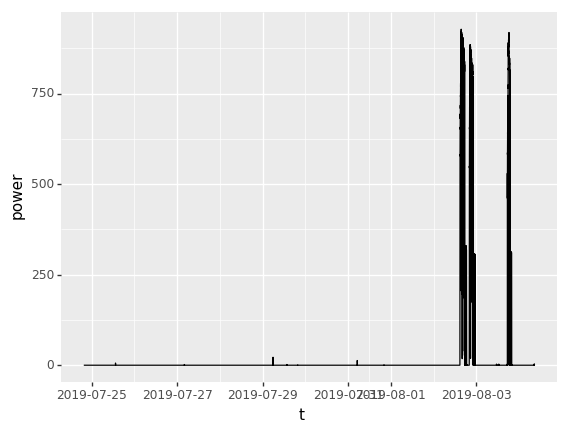

<ggplot: (-9223372036823612335)>

In [18]:
(ggplot(df_dryer_power, aes(x='t', y='power'))
    + geom_line()
)

In [19]:
def ggplot_power(start_time, end_time, df_power):
    df_plot = df_power[ (df_power['t']>start_time) & (df_power['t']<end_time)].copy()
    df_plot['time'] = df_power['t']-start_time
    return (ggplot(df_plot, aes(x='time', y='power'))
        + geom_line()
    )

In [20]:
from matplotlib.pyplot import plot
def plot_power(start_time, end_time, df_power):
    df_plot = df_power[ (df_power['t']>start_time) & (df_power['t']<end_time)].copy()
    df_plot['time'] = df_power['t']-start_time
    df_plot['time'] = df_plot['time'].apply(lambda t:t.seconds/3600+t.days*24)
    return plot(df_plot['time'], df_plot['power'])

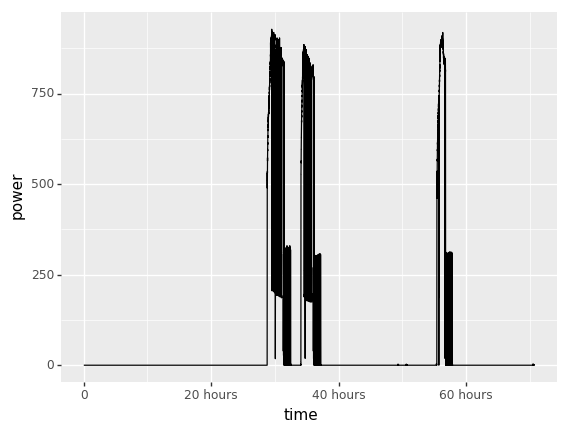

<ggplot: (-9223372036823437280)>

In [21]:
import datetime
time_start = datetime.datetime.combine(datetime.date(2019, 8, 1), 
                          datetime.time(10, 0))
time_end = datetime.datetime.combine(datetime.date(2019, 8, 4), 
                          datetime.time(15, 0))
ggplot_power(time_start, time_end, df_dryer_power)

Three dryer cycles found. Let's zoom in on the first one.

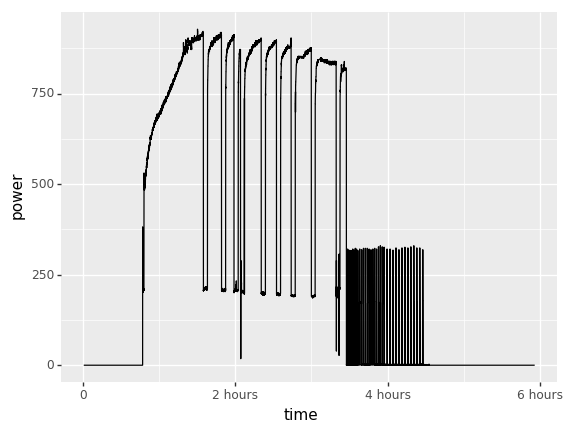

<ggplot: (-9223372036822929811)>

In [22]:
time_start = datetime.datetime.combine(datetime.date(2019, 8, 2), 
                          datetime.time(14, 0))
time_end = datetime.datetime.combine(datetime.date(2019, 8, 2), 
                          datetime.time(20, 0))
ggplot_power(time_start, time_end, df_dryer_power)

The third one looks a bit different, different program??

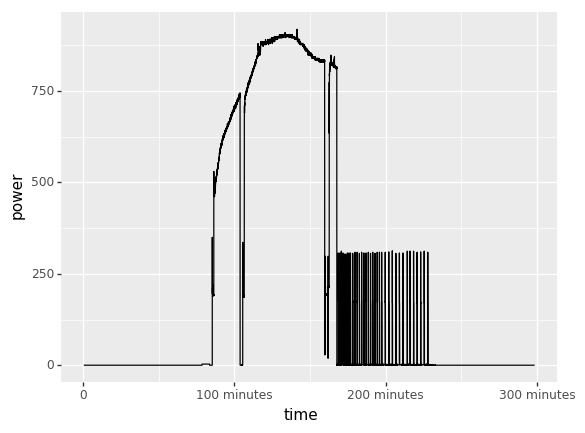

<ggplot: (31259761)>

In [23]:
time_start = datetime.datetime.combine(datetime.date(2019, 8, 3), 
                          datetime.time(16, 0))
time_end = datetime.datetime.combine(datetime.date(2019, 8, 3), 
                          datetime.time(21, 0))
ggplot_power(time_start, time_end, df_dryer_power)

Zoom on the last part of the graph, is it knitterschutz?

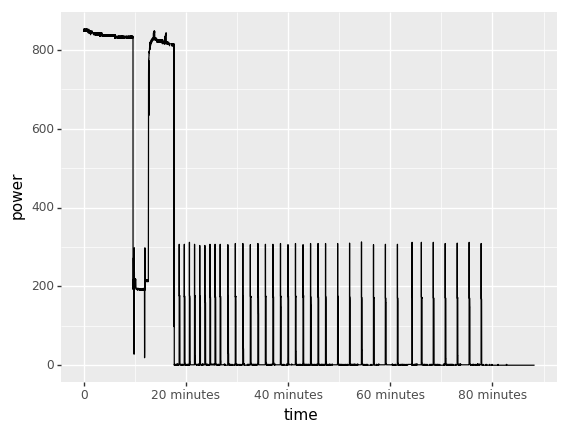

<ggplot: (31229693)>

In [24]:
time_start = datetime.datetime.combine(datetime.date(2019, 8, 3), 
                          datetime.time(18, 30))
time_end = datetime.datetime.combine(datetime.date(2019, 8, 3), 
                          datetime.time(20, 0))
ggplot_power(time_start, time_end, df_dryer_power)

## Explorative analysis: sample frequency

In [25]:
df_dryer_power['t'].min()

Timestamp('2019-07-24 19:33:37.821549')

In [26]:
df_dryer_power['t'].max()

Timestamp('2019-08-04 08:47:18.798322')

In [27]:
df_dryer_power['time'] = df_dryer_power['t'] - df_dryer_power['t'].min()
df_dryer_power['time'] = df_dryer_power['time'].apply(lambda t:t.seconds + t.days*3600*24 + t.microseconds / 1000000.0)
df_dryer_power['tdiff'] = df_dryer_power['time'].diff()
df_dryer_power[['t','time','tdiff']].head()

,t,time,tdiff
0,2019-07-24 19:33:37.821549,0.000000,NaN
27,2019-07-24 19:36:09.830836,152.009287,152.009287
39,2019-07-24 19:37:21.864949,224.043400,72.034113
55,2019-07-24 19:37:49.836446,252.014897,27.971497
58,2019-07-24 19:38:03.821925,266.000376,13.985479


In [28]:
df_dryer_power[['t','time','tdiff']].tail()

,t,time,tdiff
374009,2019-08-04 08:42:10.771238,911312.949689,13.993919
374148,2019-08-04 08:42:52.776437,911354.954888,42.005199
374177,2019-08-04 08:43:06.811946,911368.990397,14.035509
374208,2019-08-04 08:43:20.778312,911382.956763,13.966366
374629,2019-08-04 08:47:18.798322,911620.976773,238.020010


In [29]:
df_dryer_power['time'].describe()

count     43614.000000
mean     677155.969973
std      223792.511111
min           0.000000
25%      642000.358972
50%      768830.969731
75%      786879.501963
max      911620.976773
Name: time, dtype: float64

In [30]:
df_dryer_power['tdiff'].describe()

count    43613.000000
mean        20.902506
std         52.849337
min          0.083738
25%          0.311919
50%          0.963717
75%         14.003803
max       1950.423235
Name: tdiff, dtype: float64

Seems like the sensor only updates on changes of e.g. power, there is no fixed sample frequency.

## Automatic detection of dryer status

In [35]:
df_rolling = df_dryer_power.set_index(df_dryer_power['t'])[['t','time','power']]
df_rolling.head()

,t,time,power
t,,,
2019-07-24 19:33:37.821549,2019-07-24 19:33:37.821549,0.000000,0.0
2019-07-24 19:36:09.830836,2019-07-24 19:36:09.830836,152.009287,0.0
2019-07-24 19:37:21.864949,2019-07-24 19:37:21.864949,224.043400,0.0
2019-07-24 19:37:49.836446,2019-07-24 19:37:49.836446,252.014897,0.0
2019-07-24 19:38:03.821925,2019-07-24 19:38:03.821925,266.000376,0.0


### Thresholding over a window

The dryer is running if uses any power > 100 Watt at any time in the last 4 seconds.

In [36]:
df_rolling['on'] = df_rolling['power'].rolling('240s').max()>100

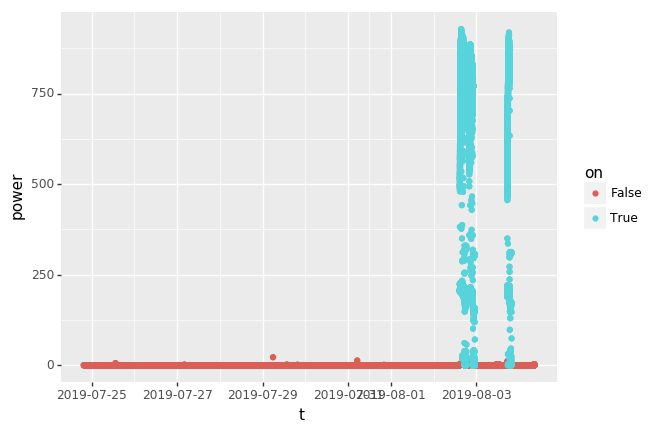

<ggplot: (-9223372036823485282)>

In [37]:
(ggplot(df_rolling, aes(x='t', y='power',color='on'))
    + geom_point()
)

In [38]:
def ggplot_power_status(start_time, end_time, df_power, status_var='on'):
    df_plot = df_power[ (df_power['t']>start_time) & (df_power['t']<end_time)].copy()
    df_plot['time'] = df_power['t']-start_time
    return (ggplot(df_plot, aes(x='time', y='power', color=status_var))
        + geom_point()        
    )

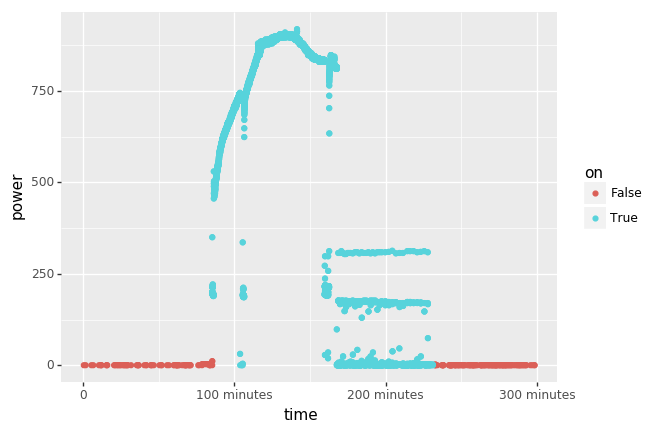

<ggplot: (-9223372036823431855)>

In [39]:
time_start = datetime.datetime.combine(datetime.date(2019, 8, 3), 
                          datetime.time(16, 0))
time_end = datetime.datetime.combine(datetime.date(2019, 8, 3), 
                          datetime.time(21, 0))
ggplot_power_status(time_start, time_end, df_rolling)

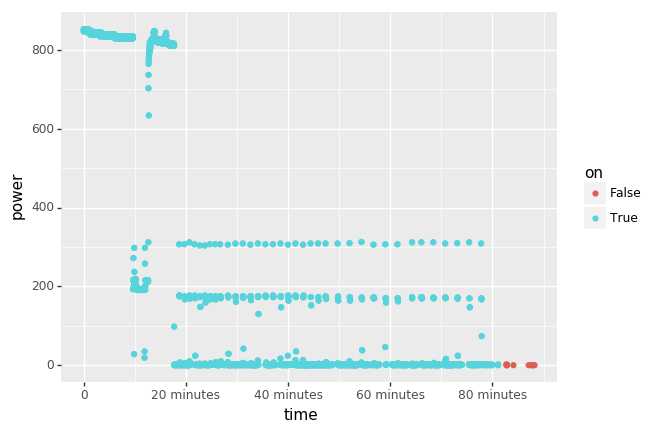

<ggplot: (31344027)>

In [40]:
time_start = datetime.datetime.combine(datetime.date(2019, 8, 3), 
                          datetime.time(18, 30))
time_end = datetime.datetime.combine(datetime.date(2019, 8, 3), 
                          datetime.time(20, 0))
ggplot_power_status(time_start, time_end, df_rolling)

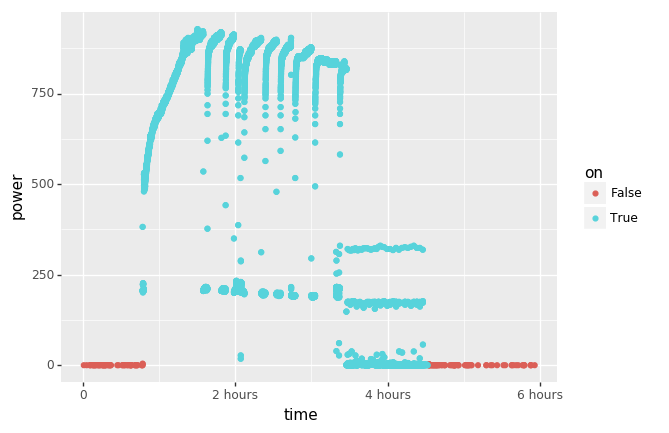

<ggplot: (-9223372036823552354)>

In [41]:
time_start = datetime.datetime.combine(datetime.date(2019, 8, 2), 
                          datetime.time(14, 0))
time_end = datetime.datetime.combine(datetime.date(2019, 8, 2), 
                          datetime.time(20, 0))
ggplot_power_status(time_start, time_end, df_rolling)

Simple thresholding seems to work well with our three samples.

## Notification of done

Done if we switch from on to off

In [42]:
done = df_rolling['on'].astype(int).diff() == -1

In [43]:
df_rolling['done'] = done

In [44]:
sum(df_rolling['done'])

3

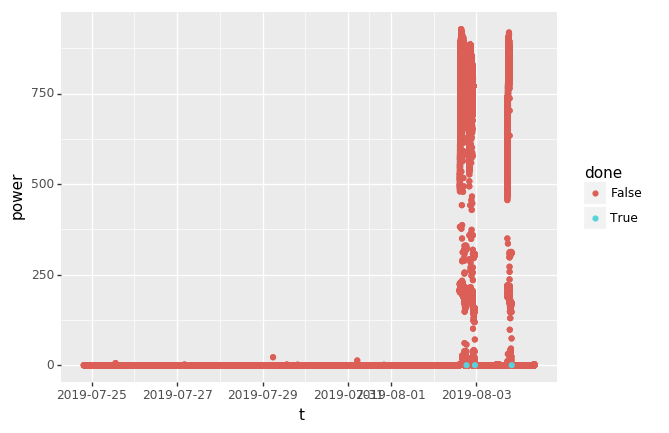

<ggplot: (31223514)>

In [45]:
(ggplot(df_rolling, aes(x='t', y='power',color='done'))
    + geom_point()
)

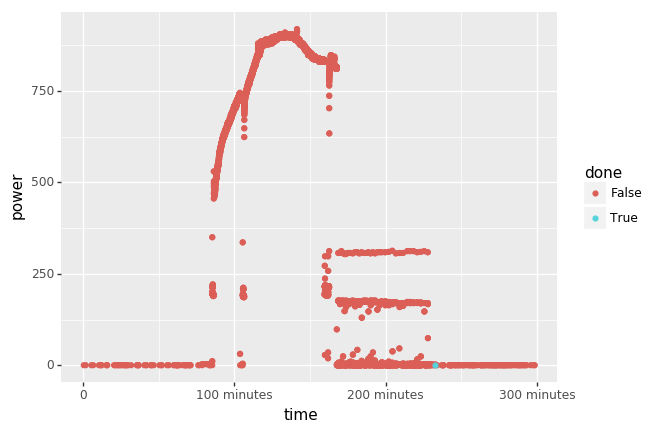

<ggplot: (-9223372036822934398)>

In [46]:
time_start = datetime.datetime.combine(datetime.date(2019, 8, 3), 
                          datetime.time(16, 0))
time_end = datetime.datetime.combine(datetime.date(2019, 8, 3), 
                          datetime.time(21, 0))
ggplot_power_status(time_start, time_end, df_rolling, 'done')

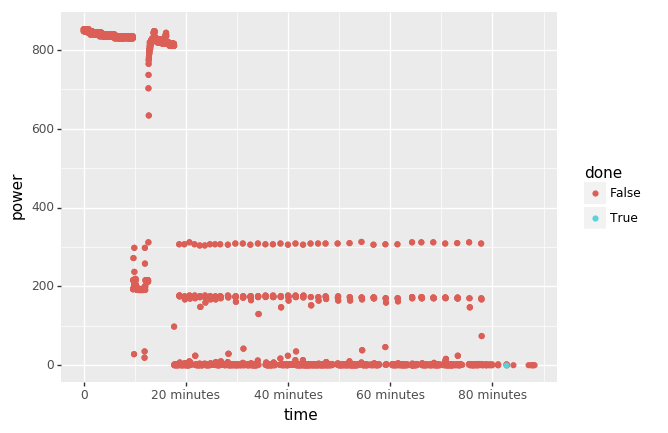

<ggplot: (-9223372036787562913)>

In [47]:
time_start = datetime.datetime.combine(datetime.date(2019, 8, 3), 
                          datetime.time(18, 30))
time_end = datetime.datetime.combine(datetime.date(2019, 8, 3), 
                          datetime.time(20, 0))
ggplot_power_status(time_start, time_end, df_rolling, 'done')

## Power consumption of the dryer (in kWh)

The power consumption of the dryer in kWh is:

$ \int_{t_{start}}^{t_{end}} power(t) dt$

with $t_{start}$ and $t_{end}$ the start and end time in hours and $power(t)$ the power at time t in kWh. I use the scipy trapezoid integration to calculate this.

In [48]:
from scipy import integrate

In [49]:
integrate.trapz(df_dryer_power['power']/1000, x=df_dryer_power['time']/3600)

4.343469666069295

In [50]:
def power_consumption(df_power, start_time, end_time):
    power = df_power[ (df_power['t']>start_time) & (df_power['t']<end_time)].copy()
    power['time'] = power['time']-power['time'].min()
    return integrate.trapz(power['power']/1000, x=power['time']/3600)

Long drying cycle:

In [51]:
time_start = datetime.datetime.combine(datetime.date(2019, 8, 2), 
                          datetime.time(14, 0))
time_end = datetime.datetime.combine(datetime.date(2019, 8, 2), 
                          datetime.time(20, 0))
power_consumption(df_dryer_power, time_start, time_end)

1.917853578595996

Short drying cycle:

In [52]:
time_start = datetime.datetime.combine(datetime.date(2019, 8, 3), 
                          datetime.time(16, 0))
time_end = datetime.datetime.combine(datetime.date(2019, 8, 3), 
                          datetime.time(21, 0))
power_consumption(df_dryer_power, time_start, time_end)

1.0479363469987275